# Neural Network with own Embedding

### Travail effectué
* NN avec 5 couches
* Sans fine tuning

In [1]:
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
from Fonctions_utils import f1_m, matrix_confusion, plot_score_model

In [2]:
df_train = pd.read_csv("../../data_models/df_train_undersampling.csv")
df_val = pd.read_csv("../../data_models/df_val.csv")
df_test = pd.read_csv("../../data_models/df_test.csv")

In [3]:
sentences_train = df_train["text_clean"].values.astype(str)
sentences_val = df_val["text_clean"].values.astype(str)
sentences_test = df_test["text_clean"].values.astype(str)

y_train = df_train["Insult"].values
y_val = df_val["Insult"].values
y_test = df_test["Insult"].values

In [4]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

The indexing is ordered after the most common words in the text, which you can see by the word the having the index 1. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which I’ll introduce in a moment

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

In [5]:
maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [6]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m,'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           358600    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 359,121
Trainable params: 359,121
Non-trainable params: 0
_________________________________________________________________


2023-06-21 11:16:20.732529: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 11:16:20.732906: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [7]:
es = EarlyStopping(monitor='val_f1_m', mode='min', patience=10)

history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    batch_size=10,
                    callbacks=[es])

Train on 1492 samples, validate on 1184 samples
Epoch 1/30
1492/1492 [==============================] - 2s 2ms/sample - loss: 0.6838 - f1_m: 0.4434 - accuracy: 0.6005 - val_loss: 0.6875 - val_f1_m: 0.4917 - val_accuracy: 0.5431
Epoch 2/30
1492/1492 [==============================] - 1s 922us/sample - loss: 0.6030 - f1_m: 0.7899 - accuracy: 0.7647 - val_loss: 0.5572 - val_f1_m: 0.5841 - val_accuracy: 0.7627
Epoch 3/30
1492/1492 [==============================] - 1s 907us/sample - loss: 0.4293 - f1_m: 0.8425 - accuracy: 0.8479 - val_loss: 0.4985 - val_f1_m: 0.6104 - val_accuracy: 0.7627
Epoch 4/30
1492/1492 [==============================] - 1s 901us/sample - loss: 0.2801 - f1_m: 0.8944 - accuracy: 0.9062 - val_loss: 0.4055 - val_f1_m: 0.6234 - val_accuracy: 0.8167
Epoch 5/30
1492/1492 [==============================] - 1s 905us/sample - loss: 0.1808 - f1_m: 0.9486 - accuracy: 0.9497 - val_loss: 0.4057 - val_f1_m: 0.6294 - val_accuracy: 0.8184
Epoch 6/30
1492/1492 [======================

## Performance

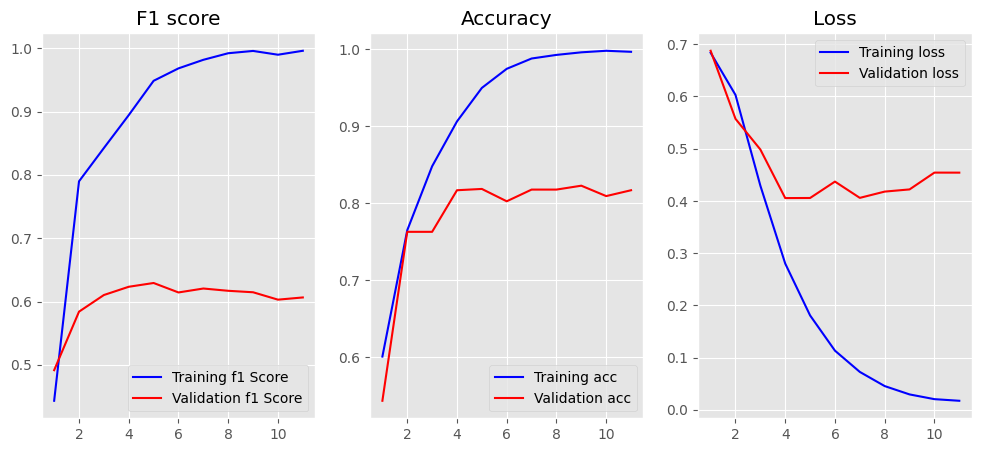

In [9]:
plot_score_model(history)

In [10]:
y_predict_test = model.predict(X_test)
y_predict_test2 = [round(item) for sublist in y_predict_test.tolist() for item in sublist]

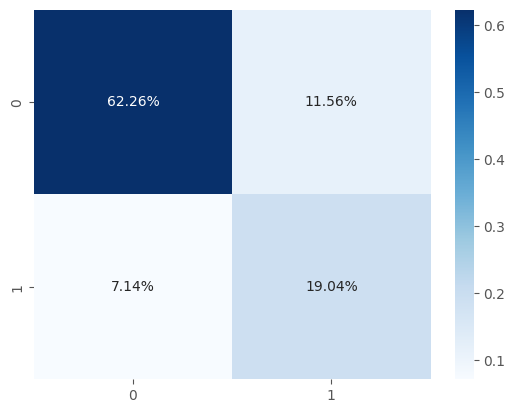

In [11]:
matrix_confusion(y_test, y_predict_test2)

In [12]:
target_names = ['Neutre', 'Insultant']
print(classification_report(y_test, y_predict_test2, target_names=target_names))

              precision    recall  f1-score   support

      Neutre       0.90      0.84      0.87      1954
   Insultant       0.62      0.73      0.67       693

    accuracy                           0.81      2647
   macro avg       0.76      0.79      0.77      2647
weighted avg       0.83      0.81      0.82      2647

